In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import qt3utils.experiments.rabi
import qt3utils.analysis.aggregation
import qt3utils.nidaq.config

In [3]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [12]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [6]:
N_cycles = 100000
rf_power = -5
clock_terminal = 'PFI0'
spcm_terminal = 'PFI12'
trigger_terminal = 'PFI1'

In [13]:
def run_scan(rf_widths, post_data_acq_process = None):
    rfsynth.set_channel_fixed_output(0, rf_power, freq)
    rfsynth.rf_on(0)
    time.sleep(0.1) #wait for RF box to turn on

    data = []
    for rf_width in rf_widths:
        rf_width = np.round(rf_width, 9)
        print(rf_width)
       
        full_cycle_ticks, period = qt3utils.experiments.rabi.pulser_setup(pulser, aom_channel = 'A',
                                                                          aom_response_time=900e-9, aom_width = 3e-6, 
                                                                          rf_channel = 'B', rf_width = rf_width,
                                                                         clock_channel = 'C')
        N_samples = int(full_cycle_ticks * N_cycles)
        daq_time = N_samples * period
        print(f'Acquiring {N_samples} at sample period of {period} seconds: total {daq_time} seconds')
        
        edge_config = qt3utils.nidaq.config.EdgeCounter()
        edge_config.configure_counter_period_measure(source_terminal = spcm_terminal,
                                                     N_samples_to_acquire_or_buffer_size = N_samples, 
                                                     clock_terminal = clock_terminal,
                                                    trigger_terminal = trigger_terminal)
        edge_config.create_counter_reader()

        data_buffer = np.zeros(N_samples)
        pulser.system.state(1) #turn on the pulser
        time.sleep(0.1) #wait to be sure its on
        edge_config.counter_task.start()
        time.sleep(daq_time*1.1)
        
        read_samples = edge_config.counter_reader.read_many_sample_double(
                                data_buffer,
                                number_of_samples_per_channel=N_samples,
                                timeout=5)
        
        edge_config.counter_task.stop()
        edge_config.counter_task.close()
        if post_data_acq_process:
            data_buffer = post_data_acq_process(data_buffer, N_cycles, full_cycle_ticks)
            
        data.append([rf_width, int(full_cycle_ticks), period, data_buffer])
    
    rfsynth.rf_off(0)
    time.sleep(0.05) #wait for RF box
    return data


In [ ]:
rf_widths = np.arange(400e-9, 15e-6, 200e-9)
freq = 2870e6


scan_data = run_scan(rf_widths, qt3utils.analysis.aggregation.reshape_sum_trace)

4e-07
Acquiring 3400000 at sample period of 2e-07 seconds: total 0.6799999999999999 seconds
6e-07
Acquiring 3600000 at sample period of 2e-07 seconds: total 0.72 seconds
8e-07
Acquiring 3800000 at sample period of 2e-07 seconds: total 0.76 seconds
1e-06
Acquiring 4000000 at sample period of 2e-07 seconds: total 0.7999999999999999 seconds
1.2e-06
Acquiring 4200000 at sample period of 2e-07 seconds: total 0.84 seconds
1.4e-06
Acquiring 4400000 at sample period of 2e-07 seconds: total 0.88 seconds
1.6e-06
Acquiring 4600000 at sample period of 2e-07 seconds: total 0.9199999999999999 seconds
1.8e-06
Acquiring 4800000 at sample period of 2e-07 seconds: total 0.96 seconds
2e-06
Acquiring 5000000 at sample period of 2e-07 seconds: total 1.0 seconds
2.2e-06
Acquiring 5200000 at sample period of 2e-07 seconds: total 1.04 seconds
2.4e-06
Acquiring 5400000 at sample period of 2e-07 seconds: total 1.0799999999999998 seconds
2.6e-06
Acquiring 5600000 at sample period of 2e-07 seconds: total 1.119999

In [ ]:
np.save('rabi_scan_v2', scan_data, allow_pickle=True)

In [16]:
def plot_rolled_trace(trace, N_cycles, N_samples_per_cycle, clock_rate, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(N_samples_per_cycle) / clock_rate, trace/N_cycles * clock_rate)

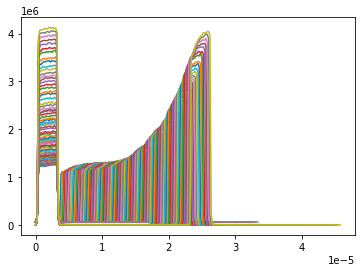

In [17]:
for scan_i in range(len(scan_data)):
    plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

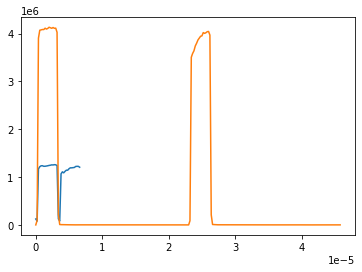

In [18]:
scan_i = 0
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)
scan_i = -1
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

In [19]:
rf_widths = np.arange(400e-9, 2e-6, 200e-9)
freq = 2870e6


scan_data = run_scan(rf_widths, qt3utils.analysis.aggregation.reshape_sum_trace)

4e-07
Acquiring 3400000 at sample period of 2e-07 seconds: total 0.6799999999999999 seconds
6e-07
Acquiring 3600000 at sample period of 2e-07 seconds: total 0.72 seconds
8e-07
Acquiring 3800000 at sample period of 2e-07 seconds: total 0.76 seconds
1e-06
Acquiring 4000000 at sample period of 2e-07 seconds: total 0.7999999999999999 seconds
1.2e-06
Acquiring 4200000 at sample period of 2e-07 seconds: total 0.84 seconds
1.4e-06
Acquiring 4400000 at sample period of 2e-07 seconds: total 0.88 seconds
1.6e-06
Acquiring 4600000 at sample period of 2e-07 seconds: total 0.9199999999999999 seconds
1.8e-06
Acquiring 4800000 at sample period of 2e-07 seconds: total 0.96 seconds


## Off Resonance


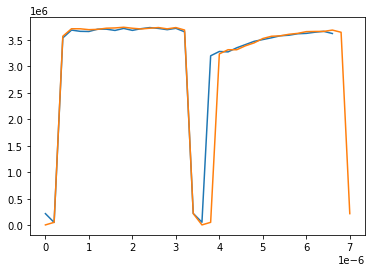

In [21]:
scan_i = 0
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)
scan_i = 1
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

In [67]:
freq = 2820e6
N_cycles = 100000
rf_power = -5
clock_terminal = 'PFI0'
spcm_terminal = 'PFI12'
trigger_terminal = 'PFI1'

In [68]:
rf_widths = np.arange(400e-9, 3e-6, 200e-9)

scan_data = run_scan(rf_widths, reshape_sum_trace)

4e-07
Acquiring 3400000 at sample period of 2e-07 seconds: total 0.6799999999999999 seconds
6e-07
Acquiring 3600000 at sample period of 2e-07 seconds: total 0.72 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<4D>" but task was already closed.
  warnings.warn(


8e-07
Acquiring 3800000 at sample period of 2e-07 seconds: total 0.76 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<4E>" but task was already closed.
  warnings.warn(


1e-06
Acquiring 4000000 at sample period of 2e-07 seconds: total 0.7999999999999999 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<4F>" but task was already closed.
  warnings.warn(


1.2e-06
Acquiring 4200000 at sample period of 2e-07 seconds: total 0.84 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<50>" but task was already closed.
  warnings.warn(


1.4e-06
Acquiring 4400000 at sample period of 2e-07 seconds: total 0.88 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<51>" but task was already closed.
  warnings.warn(


1.6e-06
Acquiring 4600000 at sample period of 2e-07 seconds: total 0.9199999999999999 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<52>" but task was already closed.
  warnings.warn(


1.8e-06
Acquiring 4800000 at sample period of 2e-07 seconds: total 0.96 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<53>" but task was already closed.
  warnings.warn(


2e-06
Acquiring 5000000 at sample period of 2e-07 seconds: total 1.0 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<54>" but task was already closed.
  warnings.warn(


2.2e-06
Acquiring 5200000 at sample period of 2e-07 seconds: total 1.04 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<55>" but task was already closed.
  warnings.warn(


2.4e-06
Acquiring 5400000 at sample period of 2e-07 seconds: total 1.0799999999999998 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<56>" but task was already closed.
  warnings.warn(


2.6e-06
Acquiring 5600000 at sample period of 2e-07 seconds: total 1.1199999999999999 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<57>" but task was already closed.
  warnings.warn(


2.8e-06
Acquiring 5800000 at sample period of 2e-07 seconds: total 1.16 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<58>" but task was already closed.
  warnings.warn(


3e-06
Acquiring 6000000 at sample period of 2e-07 seconds: total 1.2 seconds


C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<59>" but task was already closed.
  warnings.warn(
C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:457: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<5A>" but task was already closed.
  warnings.warn(


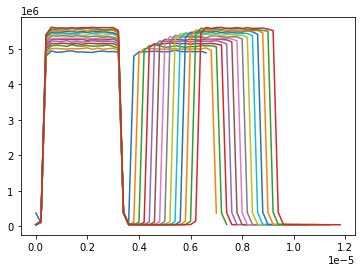

In [69]:
for scan_i in range(len(scan_data)):
    plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

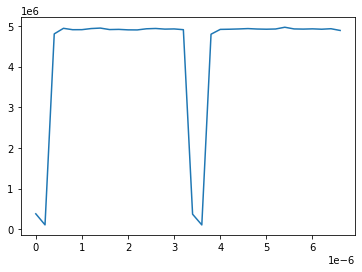

In [72]:
scan_i = 0
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

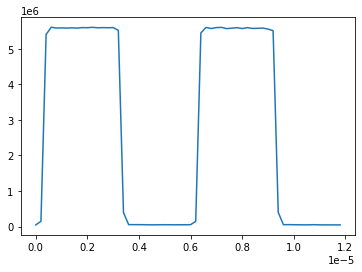

In [73]:
scan_i = -1
plot_rolled_trace(scan_data[scan_i][3], N_cycles, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)